In [1]:
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

- After importing the package to be used, I need to use `read_csv()` to read the dataset. The dataframe name is setted to `data_players`. Using a relevant path `data/players.csv`to insert the data.
- `head()` is designed to read first several rows of dataset.

In [2]:
data_players<-read_csv("data/players.csv")
head(data_players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


### Data Explanation
#### From the read dataset, we can see that there are 7 main variables. However, only three are suitable for the prediction.
- Experience: Describing a player's proficiency in a game is divided into five levels.
- Age: The player's age
- Time of playing: Time spent playing the game.

### I expect both player's age and played time are predictive of subscribing the game_related newsletter. We assume that the longer players spend playing games, the more willing they are to subscribe to game-related newsletters. Players who are too old or too young are not very willing to subscribe to newsletters.

In [4]:
players_new_frame <- mutate(data_players,subscribe =as.factor(subscribe))|> select(played_hours, Age, subscribe)|> drop_na()
players_new_frame  |> summarize(max_hr = max(played_hours), mean_hr = mean(played_hours, na.rm=TRUE))
head(players_new_frame)

max_hr,mean_hr
<dbl>,<dbl>
223.1,5.904639


played_hours,Age,subscribe
<dbl>,<dbl>,<fct>
30.3,9,TRUE
3.8,17,TRUE
0.0,17,FALSE
0.7,21,TRUE
0.1,21,TRUE
0.0,17,TRUE


## I choose the Question 1
### The age, played_hours are used to predict the player's experience using knn classification.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


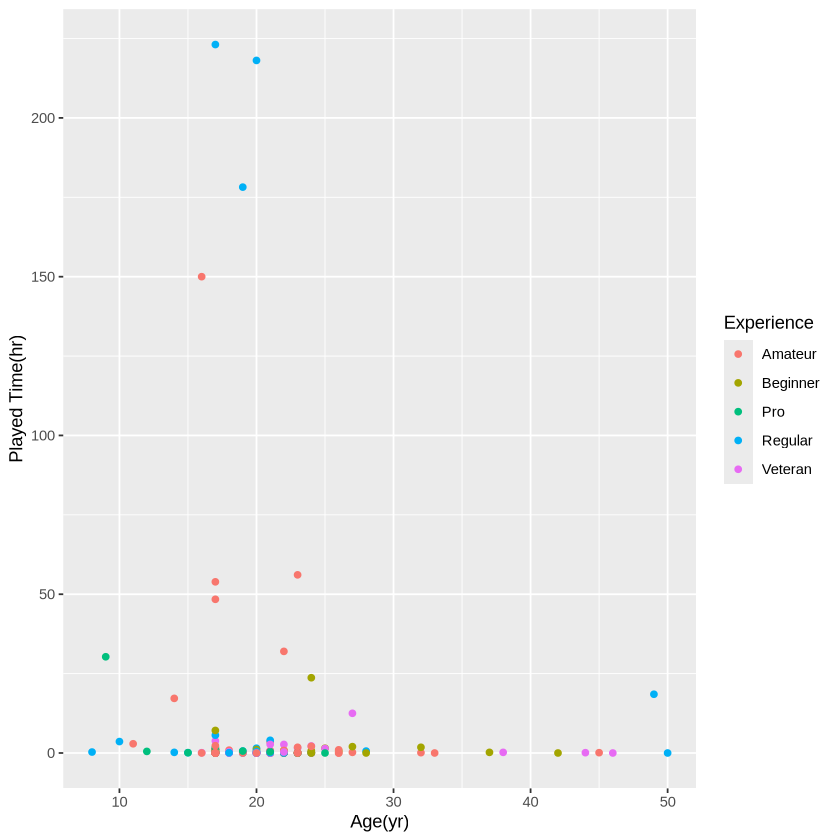

In [9]:
ggplot(data_players, aes(x=Age, y=played_hours)) +
geom_point(aes(color=experience))+
labs(x="Age(yr)",y="Played Time(hr)",color="Experience")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


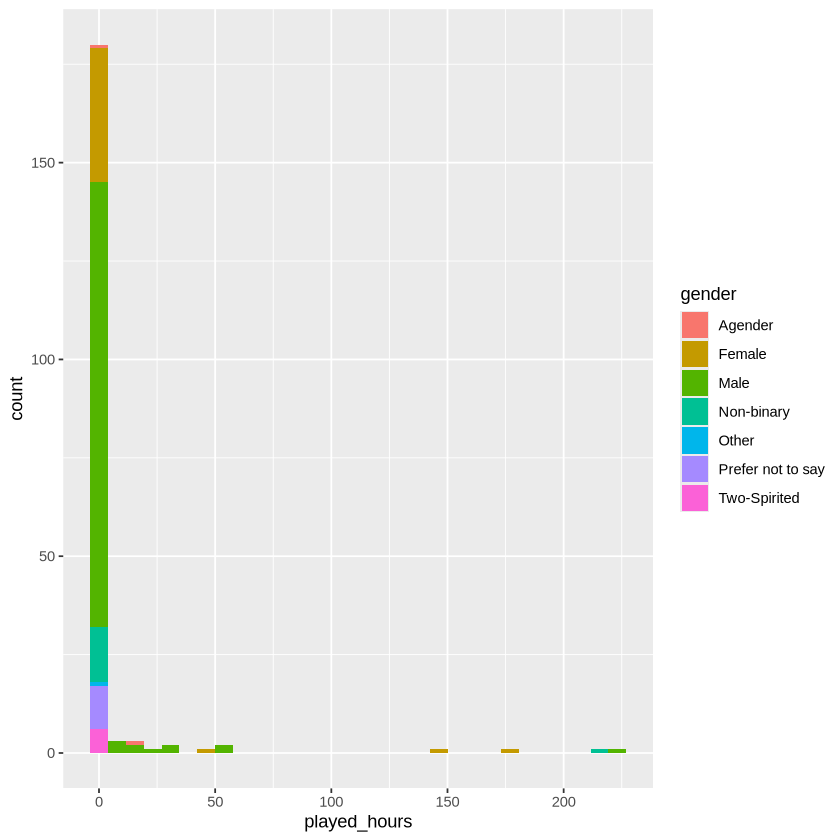

In [10]:
ggplot(data_players, aes(x=played_hours)) +
geom_histogram(aes(fill = gender))

In [12]:
players_num <- select(data_players, played_hours, Age)
players_num |> summarize(mean_hr = mean(played_hours), mean_age = mean(Age, na.rm=TRUE))
players_num |> map_df(mean, na.rm=TRUE)

mean_hr,mean_age
<dbl>,<dbl>
5.845918,20.52062


played_hours,Age
<dbl>,<dbl>
5.845918,20.52062
